[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/monografia_modelos/blob/main/new_notebook.ipynb)

In [1]:
try:
    import google.colab 
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/repos-especializacion-UdeA/monografia_modelos/refs/heads/main/init.py
    from init import init; init(force_download=False)
except ImportError:
    print("Ejecucion del notebook en entorno local")

Ejecucion del notebook en entorno local


## 1. Librerias y configuraciones previas

In [2]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

try:
    import mlflow
    print("La librería 'mlflow' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'mlflow' no está instalada.")
    print("Instalando 'mlflow'...")
    !pip install mlflow

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.
La librería 'mlflow' está instalada y se ha importado correctamente.


In [3]:
import os
import re
import pandas as pd
import seaborn as sns

* jsonfile = open("local/data/emp1.json", "w")
* jsonfile.write(emp1_str)
* jsonfile.close()

### 2. Carga del dataset

Carga y combinación de los datos en un solo dataframe

In [4]:
def load_data_to_model_csv(directory_path):
    """
    Carga todos los archivos CSV de un directorio, identifica si son conjuntos balanceados o desbalanceados
    según el nombre del archivo, y agrupa los datos en dos diccionarios.

    Args:
        directory_path (str): Ruta al directorio que contiene archivos CSV.

    Returns:
        tuple: (dict_imbalanced, dict_balanced) donde cada diccionario contiene DataFrames indexados por un identificador extraído del nombre del archivo.
    """
    all_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    print(f"Archivos encontrados: {all_files}")

    dict_imbalanced = {}
    dict_balanced = {}

    for file in all_files:
        file_path = os.path.join(directory_path, file)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error leyendo el archivo {file}: {e}")
            continue

        print(f"Archivo: {file}")

        # Se asume que el identificador está antes del primer guion bajo
        feature = file.split('_')[0]

        # Clasifica en el diccionario correspondiente
        if 'imbalanced' in file.lower():
            dict_imbalanced[feature] = df
        else:
            dict_balanced[feature] = df

        print(f"Datos cargados para '{feature}': {df.shape[0]} filas, {df.shape[1]} columnas")

    return dict_imbalanced, dict_balanced

El dataframe en el que se combinaron los datos fue: `merged_df` 

In [5]:
# Specify the directory path
directory_path = './local/data_filtered/'

# Load and merge CSV files
dict_imbalanced, dict_balanced = load_data_to_model_csv(directory_path)

Archivos encontrados: ['MAV.csv', 'MAV_filtered.csv', 'RMS.csv', 'RMS_filtered.csv', 'SSC.csv', 'SSC_filtered.csv', 'ZC.csv', 'ZC_filtered.csv']
Archivo: MAV.csv
Datos cargados para 'MAV.csv': 21594 filas, 14 columnas
Archivo: MAV_filtered.csv
Datos cargados para 'MAV': 6204 filas, 11 columnas
Archivo: RMS.csv
Datos cargados para 'RMS.csv': 21594 filas, 14 columnas
Archivo: RMS_filtered.csv
Datos cargados para 'RMS': 6204 filas, 11 columnas
Archivo: SSC.csv
Datos cargados para 'SSC.csv': 21594 filas, 14 columnas
Archivo: SSC_filtered.csv
Datos cargados para 'SSC': 6204 filas, 11 columnas
Archivo: ZC.csv
Datos cargados para 'ZC.csv': 21594 filas, 14 columnas
Archivo: ZC_filtered.csv
Datos cargados para 'ZC': 6204 filas, 11 columnas


In [6]:
fd_rms_balanced = dict_balanced['RMS']
fd_rms_balanced.head()

,RMS_f0,RMS_f1,RMS_f2,RMS_f3,RMS_f4,RMS_f5,RMS_f6,RMS_f7,RMS_f8,RMS_f9,restimulus
0,0.214203,0.027382,0.070140,0.002309,0.002581,0.005600,0.146619,0.526502,0.002533,0.311813,-1.0
1,0.477680,0.101408,0.003243,0.002414,0.002526,0.002391,0.143462,0.035936,0.002390,0.002115,-1.0
2,0.184885,0.033624,0.008280,0.002390,0.002374,0.002354,0.069650,0.098442,0.001696,0.044187,-1.0
3,0.333060,0.111076,0.002410,0.002410,0.002444,0.002384,0.096719,0.124595,0.002408,0.018831,-1.0
4,0.069107,0.001816,0.009131,0.002335,0.002494,0.003507,0.094313,0.247641,0.001772,0.136724,-1.0


In [7]:
# Display the first few rows of the merged DataFrame
fd_rms_balanced.shape

(6204, 11)

In [8]:
fd_rms_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6204 entries, 0 to 6203
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RMS_f0      6204 non-null   float64
 1   RMS_f1      6204 non-null   float64
 2   RMS_f2      6204 non-null   float64
 3   RMS_f3      6204 non-null   float64
 4   RMS_f4      6204 non-null   float64
 5   RMS_f5      6204 non-null   float64
 6   RMS_f6      6204 non-null   float64
 7   RMS_f7      6204 non-null   float64
 8   RMS_f8      6204 non-null   float64
 9   RMS_f9      6204 non-null   float64
 10  restimulus  6204 non-null   float64
dtypes: float64(11)
memory usage: 533.3 KB


In [9]:
fd_rms_balanced['restimulus'] = fd_rms_balanced['restimulus'].astype('category')
fd_rms_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6204 entries, 0 to 6203
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   RMS_f0      6204 non-null   float64 
 1   RMS_f1      6204 non-null   float64 
 2   RMS_f2      6204 non-null   float64 
 3   RMS_f3      6204 non-null   float64 
 4   RMS_f4      6204 non-null   float64 
 5   RMS_f5      6204 non-null   float64 
 6   RMS_f6      6204 non-null   float64 
 7   RMS_f7      6204 non-null   float64 
 8   RMS_f8      6204 non-null   float64 
 9   RMS_f9      6204 non-null   float64 
 10  restimulus  6204 non-null   category
dtypes: category(1), float64(10)
memory usage: 491.1 KB


Se separan las entradas de la salida

In [10]:
# Separar las entradas (features) y la salida (target)
X = fd_rms_balanced.drop(columns=['restimulus'])  # Entradas
y = fd_rms_balanced['restimulus']  # Salida

# Mostrar las dimensiones de las entradas y la salida
print(f"Dimensiones de X (entradas): {X.shape}")
print(f"Dimensiones de y (salida): {y.shape}")

Dimensiones de X (entradas): (6204, 10)
Dimensiones de y (salida): (6204,)


Se intento hacer el one hot encoding pero al entrenar el SVN salia error

In [17]:
# Convert y to one-hot encoding
# y_one_hot = pd.get_dummies(y, prefix='class')

# Display the first few rows of the one-hot encoded DataFrame
# y_one_hot.head()

Se hizo el label encoding

In [18]:
from sklearn.preprocessing import LabelEncoder

# Crear un objeto LabelEncoder
label_encoder = LabelEncoder()

# Ajustar y transformar y
y_encoded = label_encoder.fit_transform(y)

# Mostrar las primeras etiquetas codificadas
print("Etiquetas codificadas:", y_encoded[:10])

Etiquetas codificadas: [0 0 0 0 0 0 0 0 0 0]


### 3. Escalado

In [12]:
from sklearn.preprocessing import StandardScaler

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Ajustar y transformar X
X_scaled = scaler.fit_transform(X)

# Convertir el resultado a un DataFrame para mantener los nombres de las columnas
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Mostrar las primeras filas del DataFrame escalado
X_scaled.head()

,RMS_f0,RMS_f1,RMS_f2,RMS_f3,RMS_f4,RMS_f5,RMS_f6,RMS_f7,RMS_f8,RMS_f9
0,-0.275749,-0.612903,-0.377086,-0.397348,-0.506317,-0.450973,-0.531767,0.022756,-0.609921,0.050643
1,0.293710,-0.350546,-0.644820,-0.396808,-0.507107,-0.463081,-0.537397,-0.883269,-0.610461,-0.738845
2,-0.339116,-0.590780,-0.624663,-0.396933,-0.509274,-0.463221,-0.669063,-0.767827,-0.613073,-0.631593
3,-0.018862,-0.316281,-0.648155,-0.396828,-0.508278,-0.463108,-0.620777,-0.719526,-0.610391,-0.696232
4,-0.589350,-0.703516,-0.621255,-0.397215,-0.507559,-0.458867,-0.625069,-0.492272,-0.612787,-0.395696


In [13]:
SCALERS_DIR = './local/models/scalers/'
os.makedirs(SCALERS_DIR, exist_ok=True)

Guardar el escaler

In [19]:
import joblib

# Guardar el scaler en el directorio especificado
scaler_path = os.path.join(SCALERS_DIR, 'rms_scaler.pkl')
joblib.dump(scaler, scaler_path)

print(f"Scaler guardado en: {scaler_path}")

Scaler guardado en: ./local/models/scalers/rms_scaler.pkl


### 4. División de los datos 

In [20]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Mostrar las dimensiones de los conjuntos resultantes
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")

Dimensiones de X_train: (4963, 10)
Dimensiones de X_test: (1241, 10)
Dimensiones de y_train: (4963,)
Dimensiones de y_test: (1241,)


### 5. Modelado

#### 5.1. Modelo SVN

##### 5.1.1. Entrenamiento

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Definir el modelo SVM
# svm_model = SVC(kernel='rbf', random_state=42) # # ovo = one-vs-one (default)
svm_model = SVC(kernel='rbf', random_state=42, decision_function_shape='ovr') # ovr = one-vs-rest

# Definir los hiperparámetros a buscar
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Realizar predicciones con el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores hiperparámetros: {'C': 10, 'gamma': 1}
Accuracy: 0.7880741337630943

Classification Report:
               precision    recall  f1-score   support

        -1.0       0.65      0.61      0.63       310
         0.0       0.78      0.88      0.83       310
         1.0       0.82      0.83      0.83       311
        23.0       0.90      0.84      0.87       310

    accuracy                           0.79      1241
   macro avg       0.79      0.79      0.79      1241
weighted avg       0.79      0.79      0.79      1241



##### 5.1.2. Test

In [23]:
# Make predictions on the test dataset
y_pred = best_model.predict(X_test)

# Display the first few predictions
print("Predictions:", y_pred[:10])

Predictions: [23.  1. -1.  1. 23.  1.  0.  0. -1.  1.]


##### 5.1.3. Evaluacion

**Reporte**

In [ ]:
from sklearn.metrics import classification_report

# Generar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_.astype(str))

# Mostrar el reporte
print(report)

              precision    recall  f1-score   support

        -1.0       0.65      0.61      0.63       310
         0.0       0.78      0.88      0.83       310
         1.0       0.82      0.83      0.83       311
        23.0       0.90      0.84      0.87       310

    accuracy                           0.79      1241
   macro avg       0.79      0.79      0.79      1241
weighted avg       0.79      0.79      0.79      1241



**Matriz de confusión**

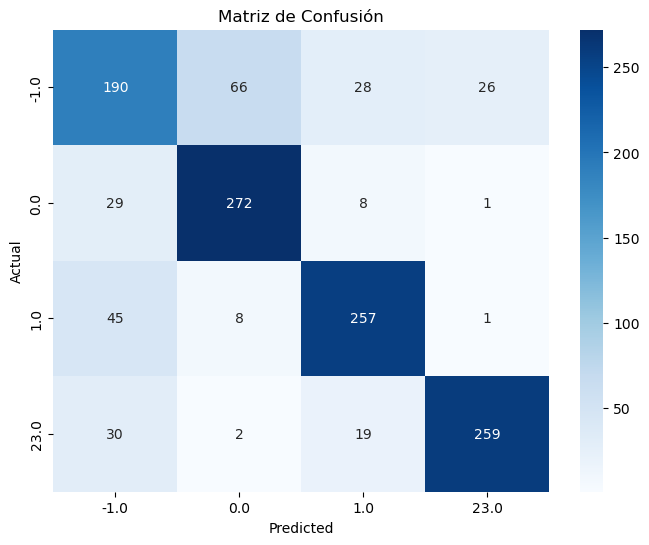

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**ROC**

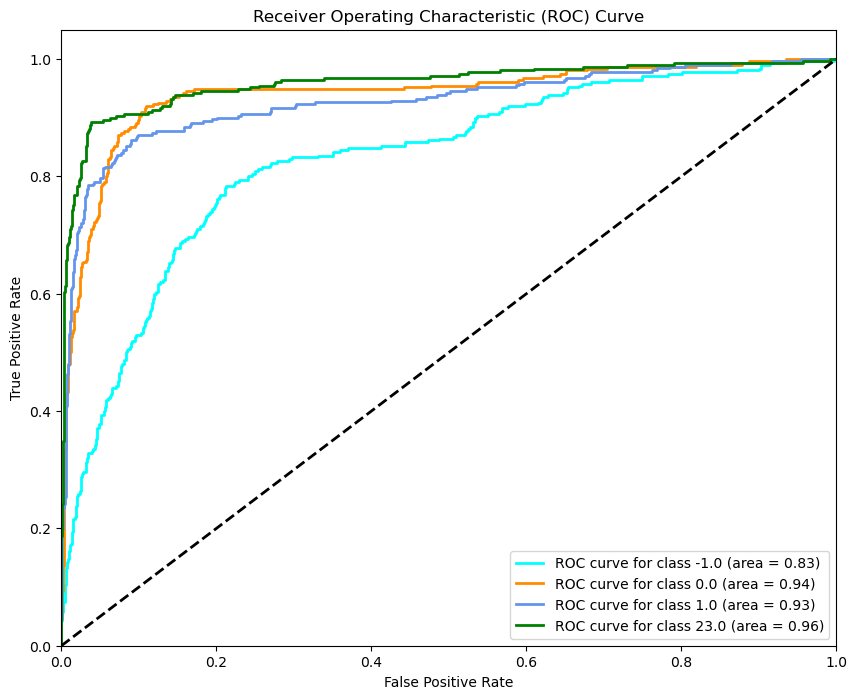

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from itertools import cycle

import matplotlib.pyplot as plt

# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=label_encoder.classes_)
n_classes = y_test_binarized.shape[1]

# Train a OneVsRestClassifier with the best SVM model
classifier = OneVsRestClassifier(best_model)
y_score = classifier.fit(X_train, label_binarize(y_train, classes=label_encoder.classes_)).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Conclusión**: Se puede eliminar las partes relacionadas con la transición quitando el -1.

In [27]:
# Crear el directorio si no existe
MODEL_DIR = './local/models/classification/'
os.makedirs(MODEL_DIR, exist_ok=True)

# Guardar el modelo SVM
svm_model_path = os.path.join(MODEL_DIR, 'svm_rms_model.pkl')
joblib.dump(best_model, svm_model_path)

print(f"Modelo SVM guardado en: {svm_model_path}")

Modelo SVM guardado en: ./local/models/classification/svm_rms_model.pkl


##### 5.1.4. Conclusiones modelo SVM

To Do...

#### 5.2. Modelo Random Forest (RF)

##### 5.2.1. Entrenamiento


In [28]:
from sklearn.ensemble import RandomForestClassifier

# Definir el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Definir los hiperparámetros a buscar
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=2)

# Ajustar el modelo a los datos de entrenamiento
grid_search_rf.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros para Random Forest:", grid_search_rf.best_params_)

# Realizar predicciones con el mejor modelo
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluar el modelo
print("Accuracy del modelo Random Forest:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report para Random Forest:\n", classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_de

Otra forma de crear el modelo es empleando **Grid Search basado en out-of-bag score**. Luego seguimos con es test

##### 5.2.2. Test

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test dataset
y_pred = best_rf_model.predict(X_test)

# Display the first few predictions
print("Predictions:", y_pred[:10])

Predictions: [ 1.  1. -1.  1. 23.  1.  0.  0. -1.  1.]


##### 5.2.3. Evaluación

In [30]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.80


**Reporte**

In [31]:
# Generate and display the classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_.astype(str))
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

        -1.0       0.64      0.66      0.65       310
         0.0       0.83      0.83      0.83       310
         1.0       0.85      0.80      0.82       311
        23.0       0.88      0.89      0.88       310

    accuracy                           0.80      1241
   macro avg       0.80      0.80      0.80      1241
weighted avg       0.80      0.80      0.80      1241



**Matriz de confusión**

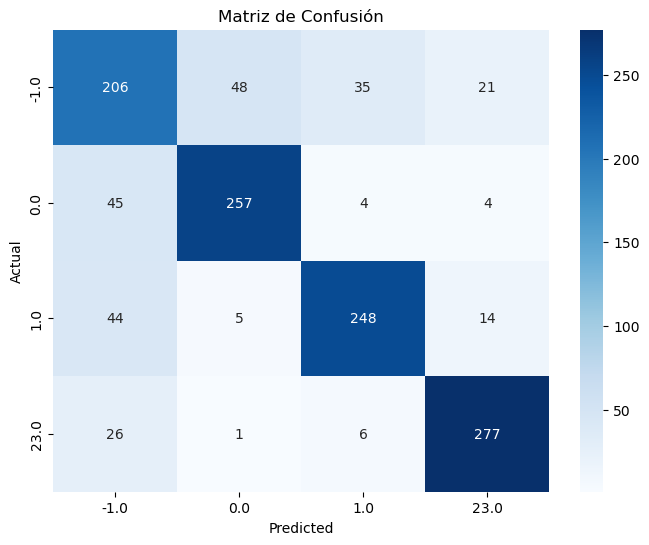

In [32]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**ROC**

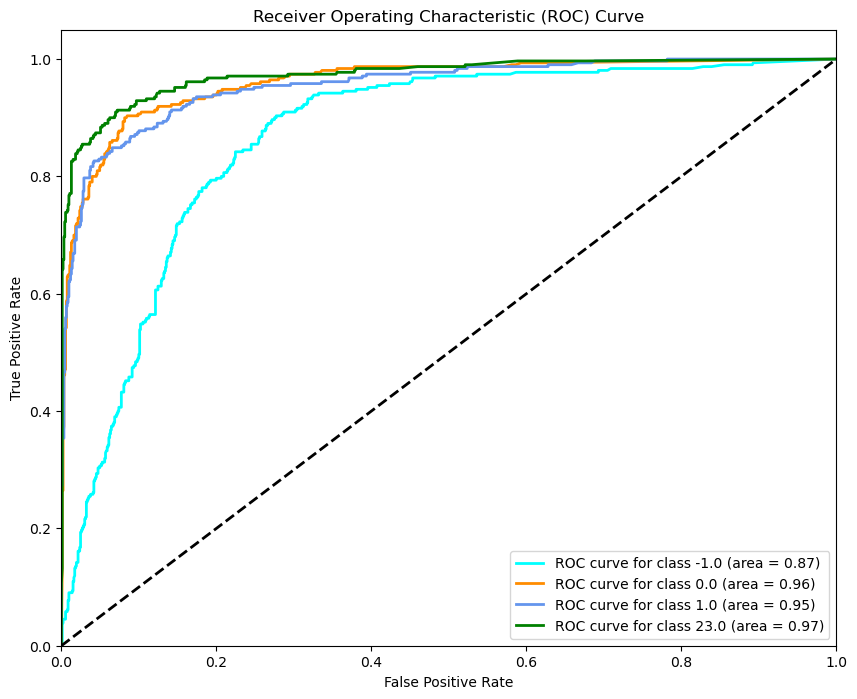

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

import matplotlib.pyplot as plt

# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=label_encoder.classes_)
n_classes = y_test_binarized.shape[1]

# Train a OneVsRestClassifier with the best RF model
classifier = OneVsRestClassifier(best_rf_model)
y_score = classifier.fit(X_train, label_binarize(y_train, classes=label_encoder.classes_)).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [35]:
# Crear el directorio si no existe
MODEL_DIR = './local/models/classification/'
os.makedirs(MODEL_DIR, exist_ok=True)

# Guardar el modelo SVM
rf_model_path = os.path.join(MODEL_DIR, 'rf_rms_model.pkl')
joblib.dump(best_rf_model, rf_model_path)

print(f"Modelo SVM guardado en: {svm_model_path}")

Modelo SVM guardado en: ./local/models/classification/svm_rms_model.pkl


#### 5.2.4. Conclusiones modelo Random Forest

To Do...


#### 5.3. KNN

To Do...

## Data frame Nuevo

### Pendiente

1. train-test split (80 - 20)
2. model fit:
   * SVM
   * KNN
   * CNN (Ultima a emplear)
   * RF 
3. Compare metrics:
   * Accuracy
   * ROC
   * F1 score
   * F2 score 

**Objetivo**: 
1. Hacer esto con MAV y RMS
2. Todas menos CNN


